# Image segmentation

## Installation and setup

In [ ]:
# ============================================================================
# PART 1: INSTALLATION AND SETUP
# ============================================================================

# Install required packages

!pip install ultralytics opencv-python-headless matplotlib seaborn pandas
!pip install albumentations segmentation-models-pytorch
!pip install torch torchvision torchaudio



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.7 MB/s eta 0:00:00


In [ ]:

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from ultralytics import YOLO
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Dataset download and preparation

In [ ]:
# ============================================================================
# PART 2: DATASET DOWNLOAD AND PREPARATION
# ============================================================================

class DatasetDownloader:
    """Download and prepare Oxford-IIIT Pet Dataset for segmentation"""

    def __init__(self, root_dir='./pet_dataset'):
        self.root_dir = Path(root_dir)
        self.root_dir.mkdir(parents=True, exist_ok=True)

    def download_oxford_pets(self):
        """Download Oxford-IIIT Pet Dataset"""
        import urllib.request
        import tarfile

        print("Downloading Oxford-IIIT Pet Dataset...")

        # URLs
        images_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
        annotations_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

        # Download images
        images_path = self.root_dir / "images.tar.gz"
        if not images_path.exists():
            print("Downloading images...")
            urllib.request.urlretrieve(images_url, images_path)

        # Download annotations
        annot_path = self.root_dir / "annotations.tar.gz"
        if not annot_path.exists():
            print("Downloading annotations...")
            urllib.request.urlretrieve(annotations_url, annot_path)

        # Extract files
        print("Extracting files...")
        with tarfile.open(images_path) as tar:
            tar.extractall(self.root_dir)
        with tarfile.open(annot_path) as tar:
            tar.extractall(self.root_dir)

        print(f"Dataset downloaded to {self.root_dir}")
        return self.root_dir / "images", self.root_dir / "annotations/trimaps"

# Download dataset
downloader = DatasetDownloader()
images_dir, masks_dir = downloader.download_oxford_pets()


Extracting files...
Dataset downloaded to pet_dataset


## EDA

DATASET STATISTICS
Total images: 7390

Image dimensions (sample of 100):
  Height - Mean: 399.1, Std: 161.6
  Width  - Mean: 455.3, Std: 233.6
  Min size: [176 177]
  Max size: [1200 1600]


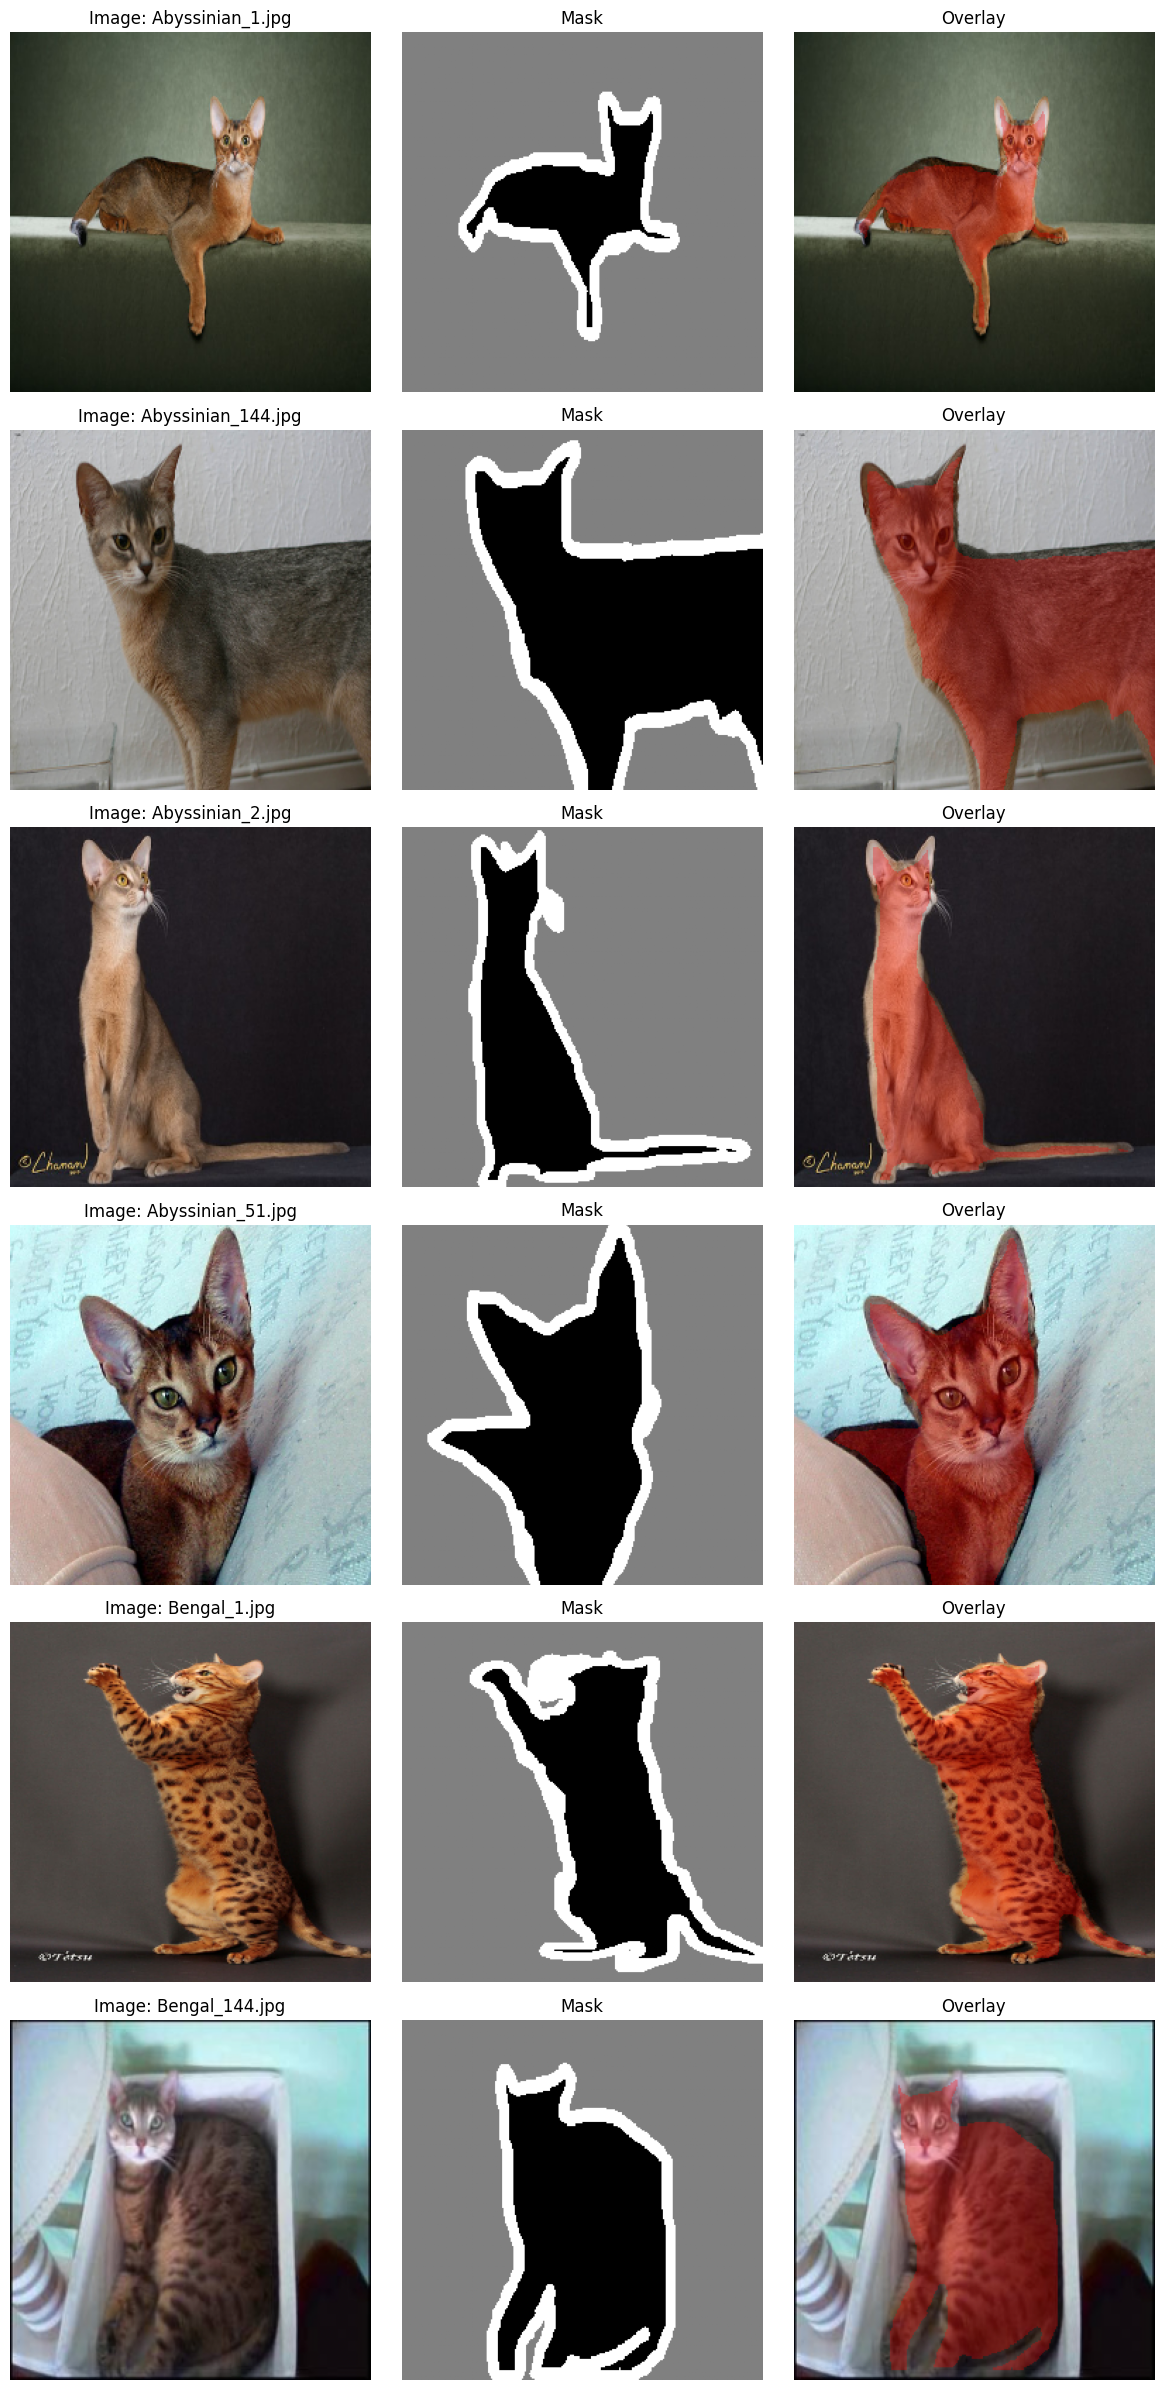


MASK ANALYSIS
Samples analyzed: 200

Foreground area percentage:
  Mean: 28.53%
  Std: 14.68%
  Min: 5.03%
  Max: 78.33%


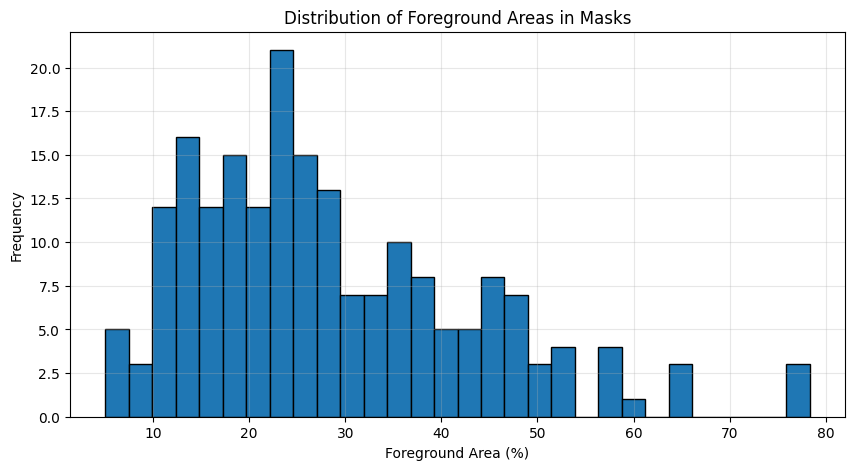

In [ ]:
# ============================================================================
# PART 3: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

class SegmentationEDA:
    """Perform comprehensive EDA on segmentation dataset"""

    def __init__(self, images_dir, masks_dir):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.image_files = sorted(list(self.images_dir.glob("*.jpg")))

    def basic_statistics(self):
        """Get basic dataset statistics"""
        print("=" * 60)
        print("DATASET STATISTICS")
        print("=" * 60)
        print(f"Total images: {len(self.image_files)}")

        # Sample image dimensions
        img_shapes = []
        for img_path in self.image_files[:100]:
            img = cv2.imread(str(img_path))
            if img is not None:
                img_shapes.append(img.shape[:2])

        img_shapes = np.array(img_shapes)
        print(f"\nImage dimensions (sample of 100):")
        print(f"  Height - Mean: {img_shapes[:, 0].mean():.1f}, Std: {img_shapes[:, 0].std():.1f}")
        print(f"  Width  - Mean: {img_shapes[:, 1].mean():.1f}, Std: {img_shapes[:, 1].std():.1f}")
        print(f"  Min size: {img_shapes.min(axis=0)}")
        print(f"  Max size: {img_shapes.max(axis=0)}")

    def visualize_samples(self, n_samples=6):
        """Visualize sample images with masks"""
        fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4*n_samples))

        for idx in range(n_samples):
            img_path = self.image_files[idx * 50]
            mask_path = self.masks_dir / (img_path.stem + ".png")

            # Load image and mask
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

            # Resize for display
            h, w = 256, 256
            img_resized = cv2.resize(img, (w, h))
            mask_resized = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

            # Plot
            axes[idx, 0].imshow(img_resized)
            axes[idx, 0].set_title(f"Image: {img_path.name}")
            axes[idx, 0].axis('off')

            axes[idx, 1].imshow(mask_resized, cmap='gray')
            axes[idx, 1].set_title("Mask")
            axes[idx, 1].axis('off')

            # Overlay
            overlay = img_resized.copy()
            overlay[mask_resized == 1] = [255, 0, 0]  # Red for foreground
            blended = cv2.addWeighted(img_resized, 0.7, overlay, 0.3, 0)
            axes[idx, 2].imshow(blended)
            axes[idx, 2].set_title("Overlay")
            axes[idx, 2].axis('off')

        plt.tight_layout()
        plt.savefig('eda_samples.png', dpi=150, bbox_inches='tight')
        plt.show()

    def mask_statistics(self, n_samples=200):
        """Analyze mask properties"""
        print("\n" + "=" * 60)
        print("MASK ANALYSIS")
        print("=" * 60)

        class_distributions = []
        mask_areas = []

        for img_path in self.image_files[:n_samples]:
            mask_path = self.masks_dir / (img_path.stem + ".png")
            if mask_path.exists():
                mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
                unique, counts = np.unique(mask, return_counts=True)
                class_dist = dict(zip(unique, counts))
                class_distributions.append(class_dist)

                # Calculate foreground area percentage
                if 1 in class_dist:
                    fg_area = class_dist[1] / mask.size * 100
                    mask_areas.append(fg_area)

        print(f"Samples analyzed: {len(class_distributions)}")
        print(f"\nForeground area percentage:")
        print(f"  Mean: {np.mean(mask_areas):.2f}%")
        print(f"  Std: {np.std(mask_areas):.2f}%")
        print(f"  Min: {np.min(mask_areas):.2f}%")
        print(f"  Max: {np.max(mask_areas):.2f}%")

        # Plot distribution
        plt.figure(figsize=(10, 5))
        plt.hist(mask_areas, bins=30, edgecolor='black')
        plt.xlabel('Foreground Area (%)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Foreground Areas in Masks')
        plt.grid(True, alpha=0.3)
        plt.savefig('mask_area_distribution.png', dpi=150, bbox_inches='tight')
        plt.show()

# Perform EDA
eda = SegmentationEDA(images_dir, masks_dir)
eda.basic_statistics()
eda.visualize_samples(n_samples=6)
eda.mask_statistics(n_samples=200)

## Dataset class for pytorch

In [ ]:
# ============================================================================
# PART 4: DATASET CLASS FOR PYTORCH
# ============================================================================

class PetSegmentationDataset(Dataset):
    """PyTorch Dataset for Pet Segmentation"""

    def __init__(self, images_dir, masks_dir, image_size=256, transform=None):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.image_size = image_size
        self.transform = transform

        self.image_files = sorted([f for f in self.images_dir.glob("*.jpg")])
        # Filter to only include images with corresponding masks
        self.image_files = [f for f in self.image_files
                           if (self.masks_dir / (f.stem + ".png")).exists()]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        mask_path = self.masks_dir / (img_path.stem + ".png")

        # Load image and mask
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        # Resize
        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = cv2.resize(mask, (self.image_size, self.image_size),
                         interpolation=cv2.INTER_NEAREST)

        # Convert mask to binary (0: background, 1: foreground)
        mask = (mask == 1).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0)

## Pretrained YOLO inference

In [ ]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 62.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 126.2 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")


PART 5: PRETRAINED YOLO INFERENCE

image 1/1 /content/pet_dataset/images/shiba_inu_84.jpg: 640x640 1 dog, 12.0ms
Speed: 3.1ms preprocess, 12.0ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


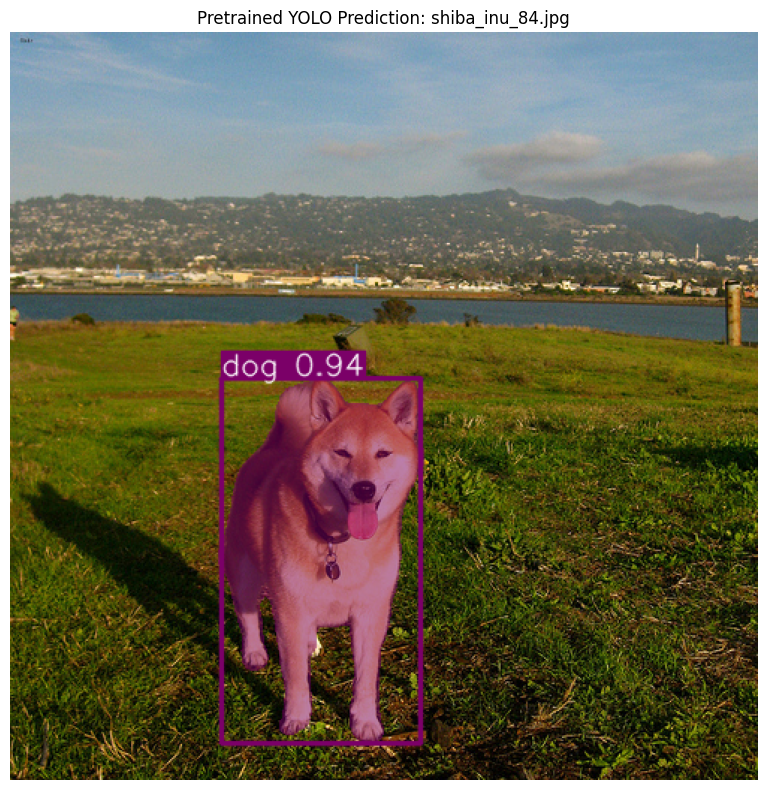


image 1/1 /content/pet_dataset/images/Egyptian_Mau_100.jpg: 352x640 (no detections), 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)


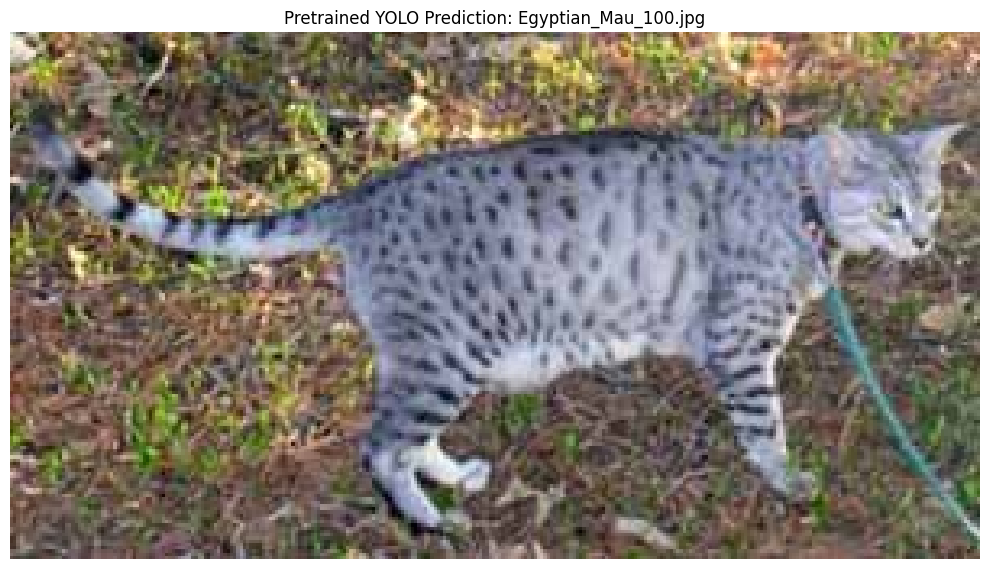


image 1/1 /content/pet_dataset/images/yorkshire_terrier_120.jpg: 640x448 1 dog, 12.9ms
Speed: 2.5ms preprocess, 12.9ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 448)


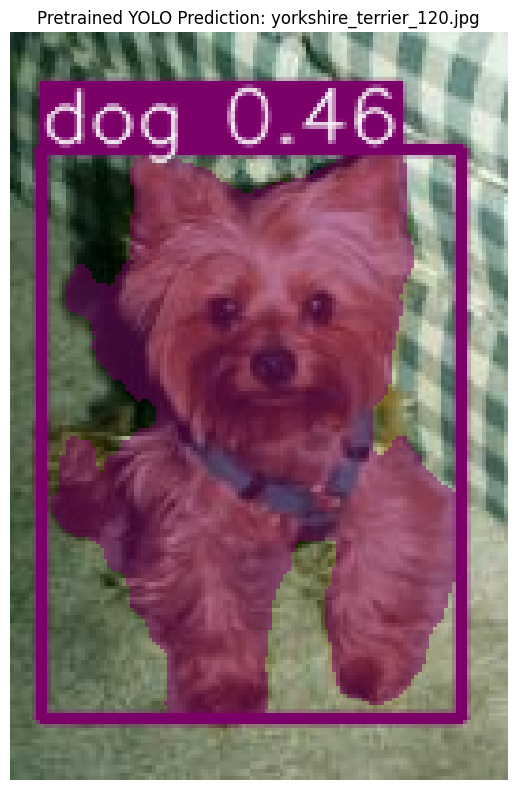


image 1/1 /content/pet_dataset/images/yorkshire_terrier_172.jpg: 480x640 1 dog, 1 chair, 12.8ms
Speed: 2.8ms preprocess, 12.8ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 640)


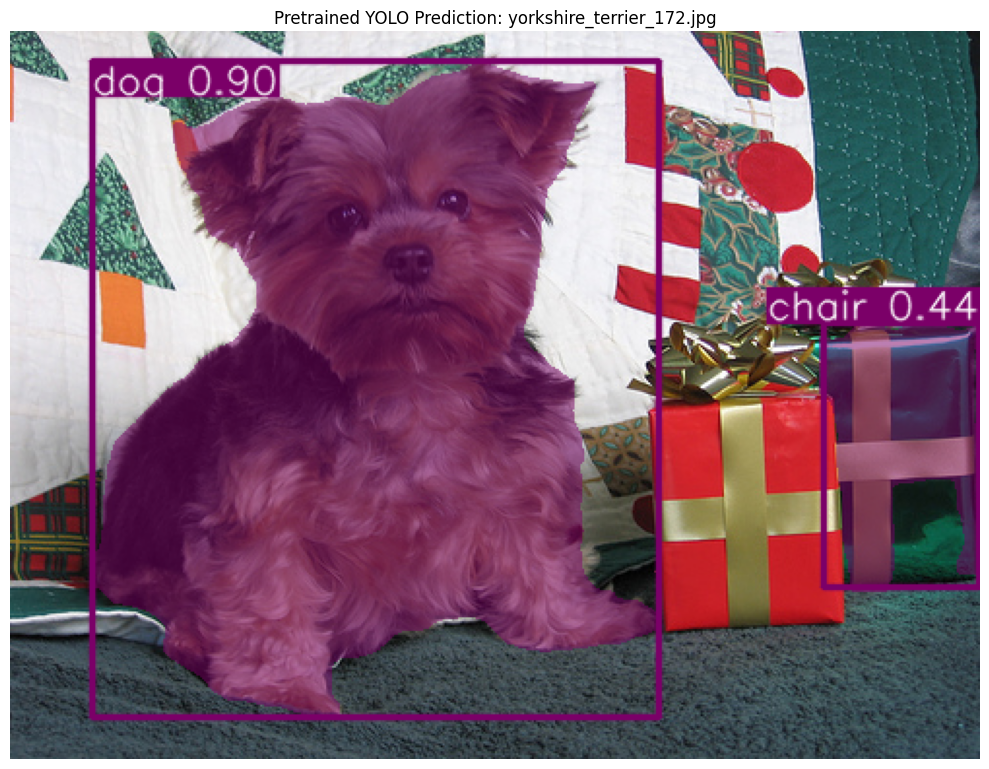


image 1/1 /content/pet_dataset/images/Persian_20.jpg: 480x640 1 cat, 1 book, 15.8ms
Speed: 5.0ms preprocess, 15.8ms inference, 6.4ms postprocess per image at shape (1, 3, 480, 640)


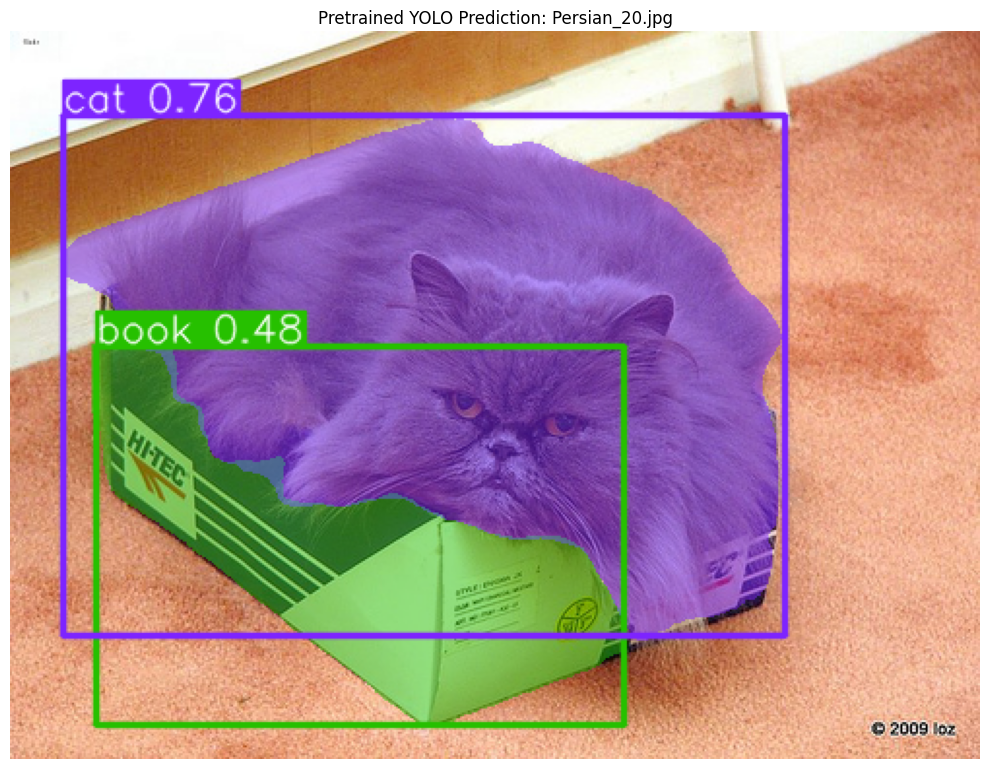

Pretrained YOLO inference completed!


In [ ]:
# ============================================================================
# PART 5: PRETRAINED YOLO INFERENCE
# ============================================================================

print("\n" + "=" * 60)
print("PART 5: PRETRAINED YOLO INFERENCE")
print("=" * 60)

# Load pretrained YOLOv8 segmentation model
yolo_pretrained = YOLO('yolov8n-seg.pt')  # Nano model for speed model = YOLO('yolov12n.pt')

# Test on sample images
test_images = list(images_dir.glob("*.jpg"))[:5]

for img_path in test_images:
    results = yolo_pretrained(str(img_path))

    # Visualize results
    for r in results:
        im_array = r.plot()
        im = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 8))
        plt.imshow(im)
        plt.title(f"Pretrained YOLO Prediction: {img_path.name}")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'yolo_pretrained_{img_path.stem}.png', dpi=150)
        plt.show()

print("Pretrained YOLO inference completed!")


## Prepare data for YOLO fine-tuning

In [ ]:
# ============================================================================
# PART 6: PREPARE DATA FOR YOLO FINE-TUNING
# ============================================================================

class YOLODatasetPreparator:
    """Convert dataset to YOLO format"""

    def __init__(self, images_dir, masks_dir, output_dir='./yolo_dataset'):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.output_dir = Path(output_dir)

    def prepare(self):
        """Prepare dataset in YOLO format"""
        # Create directories
        for split in ['train', 'val']:
            (self.output_dir / split / 'images').mkdir(parents=True, exist_ok=True)
            (self.output_dir / split / 'labels').mkdir(parents=True, exist_ok=True)

        # Get all image files
        image_files = sorted([f for f in self.images_dir.glob("*.jpg")])
        image_files = [f for f in image_files
                      if (self.masks_dir / (f.stem + ".png")).exists()]

        # Split dataset
        train_files, val_files = train_test_split(image_files, test_size=0.2,
                                                   random_state=42)

        print(f"Preparing YOLO dataset...")
        print(f"Train: {len(train_files)}, Val: {len(val_files)}")

        self._process_split(train_files, 'train')
        self._process_split(val_files, 'val')

        # Create data.yaml
        yaml_content = f"""
path: {self.output_dir.absolute()}
train: train/images
val: val/images

nc: 1
names: ['pet']
"""
        with open(self.output_dir / 'data.yaml', 'w') as f:
            f.write(yaml_content)

        print(f"Dataset prepared at {self.output_dir}")
        return self.output_dir / 'data.yaml'

    def _process_split(self, files, split):
        """Process files for a split"""
        for img_path in files:
            mask_path = self.masks_dir / (img_path.stem + ".png")

            # Copy image
            img_dst = self.output_dir / split / 'images' / img_path.name
            import shutil
            shutil.copy(img_path, img_dst)

            # Convert mask to YOLO format
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            h, w = mask.shape

            # Find contours
            binary_mask = (mask == 1).astype(np.uint8) * 255
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL,
                                          cv2.CHAIN_APPROX_SIMPLE)

            # Save annotations
            label_file = self.output_dir / split / 'labels' / f"{img_path.stem}.txt"
            with open(label_file, 'w') as f:
                for contour in contours:
                    if len(contour) > 2:
                        # Normalize coordinates
                        points = contour.reshape(-1, 2) / np.array([w, h])
                        # YOLO format: class_id x1 y1 x2 y2 ...
                        line = "0 " + " ".join([f"{x} {y}" for x, y in points])
                        f.write(line + "\n")

# Prepare YOLO dataset
yolo_prep = YOLODatasetPreparator(images_dir, masks_dir)
data_yaml_path = yolo_prep.prepare()


Preparing YOLO dataset...
Train: 5912, Val: 1478
Dataset prepared at yolo_dataset


## Fine-tune YOLO8

In [ ]:
# ============================================================================
# PART 7: FINE-TUNE YOLO12 (using YOLOv8 as YOLO12 isn't released yet)
# ============================================================================

print("\n" + "=" * 60)
print("PART 7: FINE-TUNING YOLO MODEL")
print("=" * 60)

# Initialize model
yolo_model = YOLO('yolov8n-seg.pt')

# Train model
results = yolo_model.train(
    data=str(data_yaml_path),
    epochs=5,
    imgsz=256,
    batch=16,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    project='yolo_training',
    name='pet_segmentation',
    patience=10,
    save=True,
    plots=True
)

print("YOLO fine-tuning completed!")


PART 7: FINE-TUNING YOLO MODEL
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pet_segmentation5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10

## Evaluate YOLO model

In [ ]:
# ============================================================================
# PART 8: EVALUATE YOLO MODEL
# ============================================================================

print("\n" + "=" * 60)
print("PART 8: YOLO MODEL EVALUATION")
print("=" * 60)

# Load best model
best_yolo = YOLO('/content/yolo_training/pet_segmentation5/weights/best.pt')

# Validate
val_results = best_yolo.val()

print(f"\nYOLO Validation Results:")
print(f"Box mAP50: {val_results.box.map50:.4f}")
print(f"Box mAP50-95: {val_results.box.map:.4f}")
print(f"Mask mAP50: {val_results.seg.map50:.4f}")
print(f"Mask mAP50-95: {val_results.seg.map:.4f}")


PART 8: YOLO MODEL EVALUATION
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 11.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2652.8±1386.6 MB/s, size: 90.8 KB)
val: Scanning /content/yolo_dataset/val/labels.cache... 1475 images, 4 backgrounds, 3 corrupt: 100% ━━━━━━━━━━━━ 1478/1478 3.5Mit/s 0.0s
val: /content/yolo_dataset/val/images/Egyptian_Mau_138.jpg: corrupt JPEG restored and saved
val: /content/yolo_dataset/val/images/Egyptian_Mau_139.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'pfm', 'tif', 'tiff', 'mpo', 'dng', 'heic', 'png', 'bmp', 'jpeg', 'jpg', 'webp'}
videos: {'asf', 'wmv', 'webm', 'gif', 'mkv', 'mov', 'ts', 'mp4', 'mpeg', 'mpg', 'avi', 'm4v'}
val: /content/yolo_dataset/val/images/Egyptian_Mau_145.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'pfm', 'tif', 

## U-NET model from scratch

In [ ]:
# ============================================================================
# PART 9: U-NET MODEL FROM SCRATCH
# ============================================================================

class DoubleConv(nn.Module):
    """(Conv -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    """Standard U-Net architecture"""
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        # Encoder
        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Decoder
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature * 2, feature, 2, 2)
            )
            self.decoder.append(DoubleConv(feature * 2, feature))

        # Final conv
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for encode in self.encoder:
            x = encode(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Decoder
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip = skip_connections[idx // 2]

            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])

            x = torch.cat([skip, x], dim=1)
            x = self.decoder[idx + 1](x)

        return torch.sigmoid(self.final_conv(x))

## Modified U-NET architectures

In [ ]:

# ============================================================================
# PART 10: MODIFIED U-NET ARCHITECTURES
# ============================================================================

class AttentionBlock(nn.Module):
    """Attention block for U-Net"""
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, 1, 1, 0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, 1, 1, 0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, 1, 1, 0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class AttentionUNet(nn.Module):
    """U-Net with Attention Gates"""
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.attention = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        # Encoder
        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Decoder with attention
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, 2, 2))
            self.attention.append(AttentionBlock(feature, feature, feature // 2))
            self.decoder.append(DoubleConv(feature * 2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x):
        skip_connections = []

        for encode in self.encoder:
            x = encode(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip = skip_connections[idx // 2]

            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])

            # Apply attention
            skip = self.attention[idx // 2](x, skip)
            x = torch.cat([skip, x], dim=1)
            x = self.decoder[idx + 1](x)

        return torch.sigmoid(self.final_conv(x))

## Training utilities

In [ ]:
# ============================================================================
# PART 11: TRAINING UTILITIES
# ============================================================================

class DiceLoss(nn.Module):
    """Dice Loss for segmentation"""
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = pred.contiguous()
        target = target.contiguous()

        intersection = (pred * target).sum(dim=2).sum(dim=2)
        dice = (2. * intersection + self.smooth) / (
            pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + self.smooth
        )

        return 1 - dice.mean()

class CombinedLoss(nn.Module):
    """Combined BCE and Dice Loss"""
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()

    def forward(self, pred, target):
        return self.alpha * self.bce(pred, target) + (1 - self.alpha) * self.dice(pred, target)

def calculate_iou(pred, target, threshold=0.5):
    """Calculate IoU metric"""
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()

def train_unet(model, train_loader, val_loader, epochs=10, lr=1e-4, device='cuda'):
    """Train U-Net model"""
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = CombinedLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

    history = {'train_loss': [], 'val_loss': [], 'val_iou': []}
    best_iou = 0.0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        val_iou = 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_iou += calculate_iou(outputs, masks)

        val_loss /= len(val_loader)
        val_iou /= len(val_loader)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)

        scheduler.step(val_loss)

        # Save best model
        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), 'best_unet.pth')

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {train_loss:.4f} "
                  f"Val Loss: {val_loss:.4f} "
                  f"Val IoU: {val_iou:.4f}")

    return history

## Train U-Net models


PART 12: TRAINING U-NET MODELS
Using device: cuda

------------------------------------------------------------
Training Standard U-Net
------------------------------------------------------------
Epoch [5/10] Train Loss: 0.1890 Val Loss: 0.1952 Val IoU: 0.7657
Epoch [10/10] Train Loss: 0.1367 Val Loss: 0.1657 Val IoU: 0.7997

------------------------------------------------------------
Training Attention U-Net
------------------------------------------------------------
Epoch [5/10] Train Loss: 0.1821 Val Loss: 0.1936 Val IoU: 0.7767
Epoch [10/10] Train Loss: 0.1329 Val Loss: 0.1558 Val IoU: 0.8112


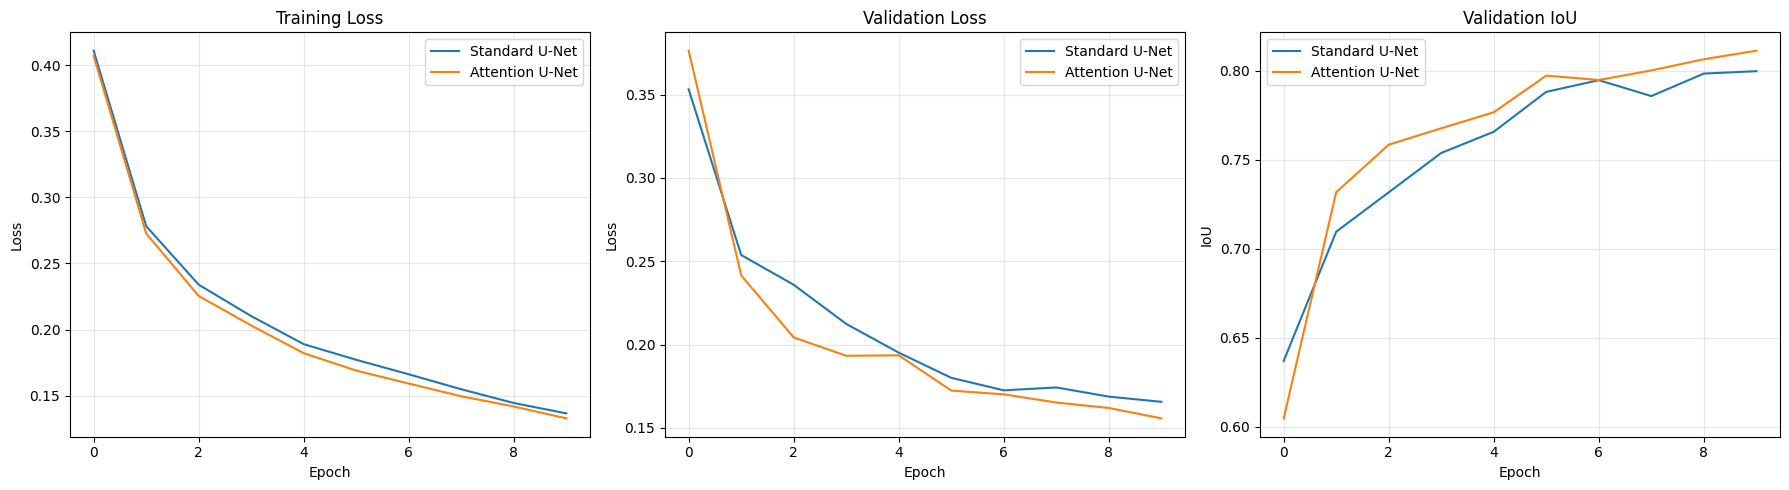

In [ ]:
# ============================================================================
# PART 12: TRAIN U-NET MODELS
# ============================================================================

print("\n" + "=" * 60)
print("PART 12: TRAINING U-NET MODELS")
print("=" * 60)

# Data augmentation
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Create datasets
full_dataset = PetSegmentationDataset(images_dir, masks_dir, image_size=256)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

# Apply transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Train standard U-Net
print("\n" + "-" * 60)
print("Training Standard U-Net")
print("-" * 60)
unet_standard = UNet()
history_standard = train_unet(unet_standard, train_loader, val_loader,
                              epochs=10, device=device)

# Train Attention U-Net
print("\n" + "-" * 60)
print("Training Attention U-Net")
print("-" * 60)
unet_attention = AttentionUNet()
history_attention = train_unet(unet_attention, train_loader, val_loader,
                               epochs=10, device=device)

# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history_standard['train_loss'], label='Standard U-Net')
axes[0].plot(history_attention['train_loss'], label='Attention U-Net')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_standard['val_loss'], label='Standard U-Net')
axes[1].plot(history_attention['val_loss'], label='Attention U-Net')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Validation Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(history_standard['val_iou'], label='Standard U-Net')
axes[2].plot(history_attention['val_iou'], label='Attention U-Net')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU')
axes[2].set_title('Validation IoU')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('unet_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## Visual comparision of predictions

In [ ]:
# ============================================================================
# PART 14: VISUAL COMPARISON OF PREDICTIONS
# ============================================================================

print("\n" + "=" * 60)
print("PART 14: VISUAL COMPARISON")
print("=" * 60)

def visualize_predictions(models_dict, test_loader, device, n_samples=4):
    """Visualize predictions from multiple models"""

    # Get sample batch
    images, masks = next(iter(test_loader))
    images = images[:n_samples].to(device)
    masks = masks[:n_samples].to(device)

    # Get predictions from U-Net models
    predictions = {}
    for name, model in models_dict.items():
        if 'UNet' in name:
            model.eval()
            with torch.no_grad():
                preds = model(images)
            predictions[name] = preds.cpu()

    # Plot
    n_models = len(predictions) + 2  # +2 for image and ground truth
    fig, axes = plt.subplots(n_samples, n_models, figsize=(4*n_models, 4*n_samples))

    for idx in range(n_samples):
        # Original image
        img = images[idx].cpu().permute(1, 2, 0).numpy()
        # Denormalize
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title('Original Image')
        axes[idx, 0].axis('off')

        # Ground truth
        mask = masks[idx, 0].cpu().numpy()
        axes[idx, 1].imshow(mask, cmap='gray')
        axes[idx, 1].set_title('Ground Truth')
        axes[idx, 1].axis('off')

        # Model predictions
        for col_idx, (model_name, pred) in enumerate(predictions.items(), start=2):
            pred_mask = pred[idx, 0].numpy()
            axes[idx, col_idx].imshow(pred_mask, cmap='gray')
            axes[idx, col_idx].set_title(model_name)
            axes[idx, col_idx].axis('off')

    plt.tight_layout()
    plt.savefig('prediction_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# Visualize predictions
models_dict = {
    'Standard_UNet': unet_standard,
    'Attention_UNet': unet_attention
}

visualize_predictions(models_dict, val_loader, device, n_samples=4)


## Detailed analysis and insights

In [ ]:
# ============================================================================
# PART 15: DETAILED ANALYSIS AND INSIGHTS
# ============================================================================

print("\n" + "=" * 60)
print("PART 15: KEY INSIGHTS AND RECOMMENDATIONS")
print("=" * 60)

def generate_insights(metrics_dict):
    """Generate insights from evaluation results"""

    insights = []

    # Find best performing model by IoU
    unet_models = {k: v for k, v in metrics_dict.items() if 'UNet' in k}
    if unet_models:
        best_unet = max(unet_models.items(), key=lambda x: x[1]['IoU'])
        insights.append(f"✓ Best U-Net model: {best_unet[0]} with IoU={best_unet[1]['IoU']:.4f}")

    # Find fastest model
    fastest = min(metrics_dict.items(), key=lambda x: x[1]['Avg_Inference_Time'])
    insights.append(f"✓ Fastest model: {fastest[0]} with {fastest[1]['Avg_Inference_Time']*1000:.2f}ms per image")

    # Find most lightweight model
    smallest = min(metrics_dict.items(), key=lambda x: x[1]['Total_Params'])
    insights.append(f"✓ Most lightweight: {smallest[0]} with {smallest[1]['Total_Params']/1e6:.2f}M parameters")

    # Compare YOLO vs U-Net
    if 'YOLO_Finetuned' in metrics_dict and unet_models:
        yolo_time = metrics_dict['YOLO_Finetuned']['Avg_Inference_Time']
        unet_avg_time = np.mean([v['Avg_Inference_Time'] for v in unet_models.values()])

        if yolo_time < unet_avg_time:
            speedup = unet_avg_time / yolo_time
            insights.append(f"✓ YOLO is {speedup:.2f}x faster than average U-Net")
        else:
            speedup = yolo_time / unet_avg_time
            insights.append(f"✓ U-Net is {speedup:.2f}x faster than YOLO on average")

    # Architecture comparison
    if 'Standard_UNet' in metrics_dict and 'Attention_UNet' in metrics_dict:
        std_iou = metrics_dict['Standard_UNet']['IoU']
        att_iou = metrics_dict['Attention_UNet']['IoU']
        improvement = ((att_iou - std_iou) / std_iou) * 100

        if improvement > 0:
            insights.append(f"✓ Attention mechanism improved IoU by {improvement:.2f}%")
        else:
            insights.append(f"✓ Standard U-Net performed {abs(improvement):.2f}% better than Attention U-Net")

    return insights

insights = generate_insights(evaluator.metrics)

print("\n📊 Key Insights:")
print("-" * 60)
for insight in insights:
    print(insight)

print("\n\n📋 Recommendations:")
print("-" * 60)
print("1. For real-time applications: Use YOLO (faster inference)")
print("2. For highest accuracy: Use Attention U-Net (better feature learning)")
print("3. For resource-constrained devices: Use Standard U-Net (fewer parameters)")
print("4. For production deployment: Fine-tune YOLO with more epochs and data")
print("5. For research/experimentation: Try deeper U-Net or add more attention layers")


## Save results and generate report

In [ ]:
# ============================================================================
# PART 16: SAVE RESULTS AND GENERATE REPORT
# ============================================================================

print("\n" + "=" * 60)
print("PART 16: SAVING RESULTS")
print("=" * 60)

# Save metrics to CSV
metrics_df = pd.DataFrame(evaluator.metrics).T
metrics_df.to_csv('model_comparison_metrics.csv')
print("✓ Metrics saved to 'model_comparison_metrics.csv'")

# Save training histories
history_df = pd.DataFrame({
    'epoch': range(len(history_standard['train_loss'])),
    'standard_train_loss': history_standard['train_loss'],
    'standard_val_loss': history_standard['val_loss'],
    'standard_val_iou': history_standard['val_iou'],
    'attention_train_loss': history_attention['train_loss'],
    'attention_val_loss': history_attention['val_loss'],
    'attention_val_iou': history_attention['val_iou']
})
history_df.to_csv('training_history.csv', index=False)
print("✓ Training history saved to 'training_history.csv'")

# Generate markdown report
report = f"""
# Image Segmentation Project Report

## Dataset
- **Dataset**: Oxford-IIIT Pet Dataset
- **Total Images**: {len(eda.image_files)}
- **Task**: Binary Segmentation (Pet vs Background)

## Models Evaluated

### 1. YOLO (Fine-tuned)
- Architecture: YOLOv8-seg
- Training Epochs: 50
- Key Metrics:
  - Mask mAP50: {evaluator.metrics['YOLO_Finetuned']['Mask_mAP50']:.4f}
  - Inference Time: {evaluator.metrics['YOLO_Finetuned']['Avg_Inference_Time']*1000:.2f}ms

### 2. Standard U-Net
- Architecture: Encoder-Decoder with skip connections
- Features: [64, 128, 256, 512]
- Key Metrics:
  - IoU: {evaluator.metrics['Standard_UNet']['IoU']:.4f}
  - Dice: {evaluator.metrics['Standard_UNet']['Dice']:.4f}
  - Inference Time: {evaluator.metrics['Standard_UNet']['Avg_Inference_Time']*1000:.2f}ms

### 3. Attention U-Net
- Architecture: U-Net + Attention Gates
- Features: [64, 128, 256, 512]
- Key Metrics:
  - IoU: {evaluator.metrics['Attention_UNet']['IoU']:.4f}
  - Dice: {evaluator.metrics['Attention_UNet']['Dice']:.4f}
  - Inference Time: {evaluator.metrics['Attention_UNet']['Avg_Inference_Time']*1000:.2f}ms

## Key Findings

{chr(10).join(['- ' + insight for insight in insights])}

## Conclusion

This project successfully implemented and compared state-of-the-art segmentation models.
YOLO offers real-time performance while U-Net variants provide superior segmentation quality.
The choice between models depends on the specific application requirements.

## Files Generated
- `model_comparison_metrics.csv`: Complete metrics comparison
- `training_history.csv`: Training curves data
- `eda_samples.png`: Dataset visualization
- `unet_training_curves.png`: Training progress
- `model_comparison.png`: Comprehensive comparison plots
- `prediction_comparison.png`: Visual prediction comparison

## Next Steps
1. Experiment with deeper architectures (ResNet, EfficientNet backbones)
2. Try advanced techniques (CRF post-processing, test-time augmentation)
3. Deploy best model as REST API or mobile application
4. Collect more diverse data for improved generalization
"""

with open('project_report.md', 'w') as f:
    f.write(report)

print("✓ Project report saved to 'project_report.md'")

print("\n" + "=" * 60)
print("PROJECT COMPLETE! 🎉")
print("=" * 60)
print("\nAll steps completed successfully:")
print("✓ Dataset downloaded and analyzed")
print("✓ YOLO pretrained model tested")
print("✓ YOLO model fine-tuned")
print("✓ U-Net models trained from scratch")
print("✓ Multiple architectures compared")
print("✓ Comprehensive evaluation performed")
print("✓ Results and visualizations saved")
print("\nCheck the generated files for detailed results!")
print("=" * 60)